## Live Risk and Performance Predict

### Summary 

While we are working on delivering live risk in gs-quant, computing risk real-time for large portfolios can be computationaly expensive. In this notebook, I team up with FICC Derivatives' David Vanden Bon to introduce a simple and lightweight framework for approximating it. This means you can compute your end of day risk and connect a live market feed to this code to estimate how performance, delta and gamma risk are changing for your book in real time. 

You can also use this framework to predict performance - that is, estimate impact of a hypothetical market move, which can be a useful risk management tool.

More specifically, we do this by calculating a delta ladder for our portfolio via applying a number of spot shocks. We use the delta values to fit a polynomial for each instrument in the curve and then use this polynomial to appriximate delta, gamma and pnl for any given market move in these instruments.

Let's get started!

Don't forget to check out the [What's New](#What's-New) section for the latest gs-quant additions.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Create or load portfolio](#2---Create-or-load-portfolio)
* [3 - Calculate delta ladder](#3---Calculate-delta-ladder)
* [4 - Fit polynomial](#4---Fit-polynomial)
* [5 - Estimate performance and risk for any market move](#5---Estimate-performance-and-risk-for-any-market-move)
* [What's New](#What's-New)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.130.

In [18]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',))

### 2 - Create or load portfolio

The goal for this section is to load your own book. If you are an internal user please reach out for ways to connect your book.

If you are an external user, we have additional natural language processing tools to help map your book coming soon! 

For this note, I'll create a sample portfolio of a combination of 3m, 1y, 2y and 3y expiry payer and receiver swaptions on 5y, 10y, 15y and 20y tails struck 10, 20 and 30bps OTMF and resolve it to fix all the relative parameters.

In [19]:
from gs_quant.instrument import IRSwaption
from gs_quant.markets.portfolio import Portfolio
from gs_quant.common import PayReceive, Currency

ccy = Currency.USD
payers = [IRSwaption(PayReceive.Pay, termination_date='{}y'.format(t), notional_currency=ccy, 
                     expiration_date='{}m'.format(e), strike='a+{}'.format(s)) 
          for t in [5, 10, 15, 20] for e in [3, 12, 24, 36] for s in [10, 20, 30]]

receivers = [IRSwaption(PayReceive.Receive, termination_date='{}y'.format(t), notional_currency=ccy, 
                     expiration_date='{}m'.format(e), strike='a-{}'.format(s)) 
          for t in [5, 10, 15, 20] for e in [3, 12, 24, 36] for s in [10, 20, 30]]

portfolio = Portfolio(payers + receivers)
portfolio.resolve()

### 3 - Calculate Delta Ladder

Now let's take our portfolio and calculate a delta ladder by shocking spot with varying shifts (where 0 our portfolio delta without any shocks applied). Each row in the resulting dataframe corresponds to a different instrument. We will use this delta information to fit a polynomial for each of these instruments in the next step.

In [20]:
from gs_quant.markets import PricingContext
from gs_quant.risk import MarketDataShockBasedScenario, MarketDataPattern, MarketDataShock, MarketDataShockType, Price, IRDeltaLocalCcy

# calculate the base delta case (current delta of portfolio - 0bp shift in the rates)
delta = portfolio.calc(IRDeltaLocalCcy).aggregate().rename(columns = {'value': 0})

# calculate delta ladder (local delta for a number of shifts)
shifts = [-50, -40, -30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30, 40, 50]
results = {}
with PricingContext(is_async=True):
    for shift in shifts:
        with MarketDataShockBasedScenario({
            MarketDataPattern('IR', ccy): MarketDataShock(MarketDataShockType.Absolute, shift / 10000),
            MarketDataPattern('IR Reset', '{}-3m'.format(ccy)): MarketDataShock(MarketDataShockType.Absolute, shift / 10000),
            MarketDataPattern('IR Reset', '{}-6m'.format(ccy)): MarketDataShock(MarketDataShockType.Absolute, shift / 10000)
        }):
            results[shift] = portfolio.calc(IRDeltaLocalCcy)

# aggregate delta and insert into dataframe
for shift in shifts:
    delta[shift] = results[shift].aggregate().value

# insert base delta into sorted numerical column order    
cols = list(delta.columns)
column_list = cols[:4] + sorted(cols[4:])
delta = delta[column_list]
delta.head(3)

,mkt_type,mkt_asset,mkt_class,mkt_point,-50,-40,-30,-20,-10,-5,-2,0,2,5,10,20,30,40,50
0,IR,USD,CASH,O/N,-96.652300,-87.508851,-80.140622,-74.702595,-71.280237,-70.330161,-70.001395,-69.881709,-69.840876,-69.925542,-70.448960,-72.866759,-76.972091,-82.564403,-89.423074
1,IR,USD,CASH,CASH STUB,19236.462658,15938.264198,12100.009823,7851.226480,3375.412126,1107.540696,-251.889772,-1155.410051,-2055.450143,-3397.138702,-5601.994693,-9838.668869,-13744.821189,-17227.777252,-20248.264302
2,IR,USD,FRA,JUN20,58295.744762,48164.753974,36542.379396,23781.786655,10376.965634,3584.071217,-489.994901,-3198.958126,-5898.759200,-9925.239905,-16549.585996,-29314.223366,-41151.872378,-51799.726695,-61135.816203


### 4 - Fit Polynomial

With delta accross various shocks for each instrument in hand (the frame above), we can calculate a polynomial which fits the evolution of delta across the shifts for each instrument.

`coeffs` will give us the polynomial (order number of shifts-1) coefficients for each instrument, thus `coeffs` is a matrix of size `len(delta)` x `len(shifts)` where each matrix row is a polynomial corresponding to the coefficients for each instrument. In this example it will be 30x15.

We'll use this polynomial in the next step to extrapolate delta, gamma and performance to any market move.

Note polynomial fitting is as much as art it is a science and additional techniques can be used here to avoid overfitting which can produce kinks and other undesirable effects.

In [21]:
import numpy as np

coeffs = [np.polynomial.polynomial.polyfit(shifts, row.values, len(shifts) - 1) for _, row in delta[shifts].iterrows()]

We can now visualize what the polynomial looks for a particular point in the curve - '5Y' in the example below. The points in the graph are the shocks we fit the polynomial on for the '5Y' instrument.

This means that for '5Y' instrument (and the rest of instruments in the table above) we can plug in any market move and get the expected delta (plug in x=spot and get y=delta, which we'll do in the next step).

Text(0, 0.5, 'Delta')

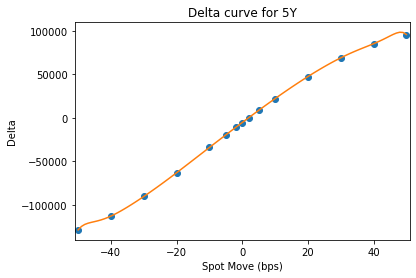

In [22]:
import matplotlib.pyplot as plt

point = '5Y'

x = shifts
y = delta[delta['mkt_point'] == point][shifts].values[0]
coefficients = np.polyfit(x, y, len(x)-1)
poly = np.poly1d(coefficients)

new_x = np.linspace(x[0], x[-1], 100)
new_y = poly(new_x)

plt.plot(x, y, "o", new_x, new_y)
plt.xlim([x[0]-1, x[-1] + 1])
plt.title('Delta curve for {}'.format(point))
plt.xlabel('Spot Move (bps)')
plt.ylabel('Delta')

### 5 - Predicting Performance and Risk

We can already get expected delta for any market move using our polynomial above - with a big of simple math, we can also get gamma (first derivative) and pnl approximation. Let's define a few functions to help us to that.

In [23]:
def delta_f(inst_coeff, market_move):
    return sum([c*market_move**(i) for i, c in enumerate(inst_coeff)])

def gamma_f(inst_coeff, market_move):
    return sum([(i + 1)*c*market_move**(i) for i, c in enumerate(inst_coeff[1:])])
    
def pnl_f(inst_coeff, market_move):
    return sum([(c*market_move**(i + 1))/(i + 1) for i, c in enumerate(inst_coeff)])
   
def get_derived_values(inst_coeff, market_move):
    b_delta = inst_coeff[0]
    b_gamma = gamma_f(inst_coeff, 0)
    
    new_delta = delta_f(inst_coeff, market_move)
    new_gamma = gamma_f(inst_coeff, market_move)

    delta_pnl = b_delta * market_move
    gamma_pnl = pnl_f(inst_coeff, market_move) - delta_pnl
    
    return {'current_delta': b_delta, 'current_gamma': b_gamma, 'new_delta': new_delta, 'new_gamma': new_gamma,
            'delta_pnl': delta_pnl, 'gamma_pnl': gamma_pnl}

Now imagine you have a live market data feed - you can plug that in for `market_moves` and get live risk on your book. You can also plug in any market move to predict pnl and risk for your book. 

Here I apply a flat 22bp move to all instruments but you can specify different moves for each instrument using the `market_moves` dictionary. As an example, I'll update O/N to 9bps and 10Y swap to 25.

In [24]:
# plug in move (bps) - flat accross all instruments or construct custom dictionary
move = 22
market_moves = dict(zip(delta.mkt_point.values, len(delta.mkt_point)*[move]))
market_moves['O/N'] = 9
market_moves['10Y'] = 25

Let's now calculate estimated delta, gamma and pnl given these market moves.

In [25]:
import pandas as pd 

# calculate values for all the instruments
instruments = delta['mkt_point']
results = pd.DataFrame([get_derived_values(coeffs[delta[delta['mkt_point'] == instrument].index[0]], 
                              market_moves[instrument]) for instrument in list(instruments)])
results.index = instruments
results.head(3)

,current_delta,current_gamma,new_delta,new_gamma,delta_pnl,gamma_pnl
mkt_point,,,,,,
O/N,-69.881709,0.040065,-70.306373,-0.133143,-628.935377,-0.742775
CASH STUB,-1155.410051,-450.968775,-10675.092828,-418.613276,-25419.021126,-106376.459182
JUN20,-3198.958126,-1352.429189,-31787.348638,-1230.087633,-70377.078769,-319716.680302


We now have delta, gamma and delta given a specified move in each instrument. Current delta and gamma are values for the current portfolio and new delta and gamma are values after the market move is applied.

Now to better understand the results, let's examine them visually! Note all of these values are approximations and may differ from actual performance and risk for the book.

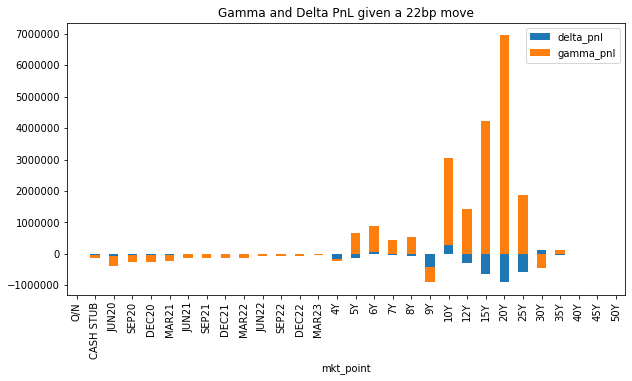

In [26]:
results[['delta_pnl', 'gamma_pnl']].plot(kind='bar', stacked=True, title='Gamma and Delta PnL given a {}bp move'.format(move), figsize=(10, 5))

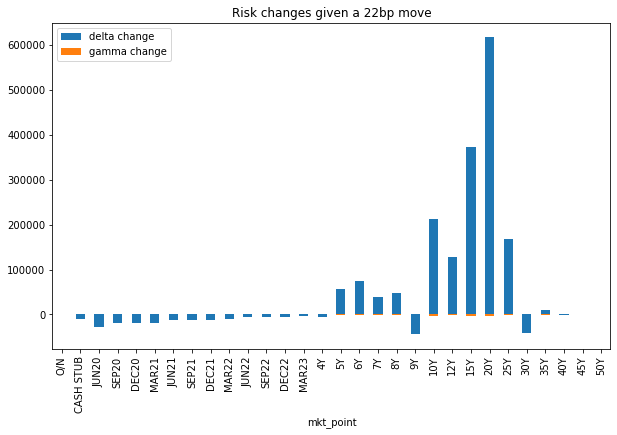

In [27]:
risk_changes = pd.DataFrame([results.new_delta - results.current_delta, results.new_gamma - results.current_gamma]).T
risk_changes.columns = ['delta change', 'gamma change']
risk_changes.plot(kind='bar', stacked=True, figsize=(10, 6), title='Risk changes given a {}bp move'.format(move))

Please reach out with your thoughts and feedback!

### What's New

* New `IRXccySwapFixFlt` and `IRXccySwapFixFix` instruments (`from gs_quant.instruments import IRXccySwapFixFlt, IRXccySwapFixFix`)
* Improved error handling
* Improved computational efficiency - see `4-Delta Hedging` for examples